In [56]:
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
class Tree(object):
    def __init__(self, depth=0, *args, **kwargs):
        self.depth = depth
        self.f_index = 0
        self.w = None
        self.cat_val = None
        self.left = None
        self.right = None

    def set_left(self, l):
        self.left = l

    def set_right(self, r):
        self.right = r

    def set_children(self, l, r):
        self.left = l
        self.right = r

    def set_cat(self, val):
        self.cat_val = val

    def get_cat(self):
        return self.cat_val

    def set_w(self, w, f_index):
        self.w = w
        self.f_index = f_index
    

In [3]:
class DecisionTreeClassification(torch.nn.Module):
    """Normal DecisionTreeClassification"""
    def __init__(self, n_features, cat_indexs=[], max_depth=3,
        ig_func='entropy', split='random_k', *args, **kwargs):
        super(DecisionTreeClassification, self).__init__(*args, **kwargs)
        self.max_depth = max_depth
        self.types = [0]*n_features
        self.tree = None
        for xi in cat_indexs:
            self.types[xi] = 1
        
        if ig_func == 'entropy':
            self.ig_func = DecisionTreeClassification.ig_entropy
        else:
            raise "not an information gain function"
        
        if split == 'random':
            self.split_func = self.random_split
        elif split == 'best':
            self.split_func = self.best_split
        elif split == 'random_k':
            self.split_func = self.random_k_split
        else:
            raise "Try 'random' or 'best' split method"

    def train(self, X, Y):
        self.tree = Tree()
        rec_list = [(self.tree, X, Y)]
        while len(rec_list) and rec_list[0][0].depth <= self.max_depth:
            node = rec_list.pop(0)
            f_index, f_val = self.split_func(node[1], node[2])
            node[0].set_w(f_val, f_index)
            node[0].set_cat(self.p_argmax(node[2])[0])
            nl = Tree(node[0].depth + 1)
            nr = Tree(node[0].depth + 1)
            node[0].set_children(nl,nr)
            S = self.split(node[1], node[2], f_index, f_val)
            
            if len(S[2]):
                rec_list.append((nl, S[0], S[2]))

            if len(S[3]):
                rec_list.append((nr, S[1], S[3]))

        return self.tree

    def predict(self, X):
        if self.tree is None:
            return None
        yp = np.empty(len(X))
        for i, xi in enumerate(X):
            yp[i] = self.forward(xi)
        return yp

    def forward(self, x):
        res = None
        node = self.tree
        while res is None:
            ki = x[node.f_index] == node.w if self.types[node.f_index] else x[node.f_index] <= node.w
            if ki:
                if node.left is None or node.left.get_cat() is None:
                    res = node.get_cat()
                else:
                    node = node.left
            else:
                if node.right is None or node.right.get_cat() is None:
                    res = node.get_cat()
                else:
                    node = node.right
        return res

    def split(self, X, Y, f_index, f_val):
        ki = X[:, f_index] == f_val if self.types[f_index] else X[:, f_index] <= f_val
        xl, xr = X[ki], X[~ki]
        yl, yr = Y[ki], Y[~ki]
        return xl, xr, yl, yr        

    def split_feature(self, X, Y, f_index):
        vals = np.unique(X[:, f_index])
        b_ig = 0
        b_val = vals[0]
        for v in vals:
            S = self.split(X, Y, f_index, v)
            if not len(S[2]) or not len(S[3]):
                continue
            ig = self.ig_func(Y, S[2:])
            if ig > b_ig:
                b_ig = ig
                b_val = v
        return b_ig, b_val

    def best_split(self, X, Y):
        b_fi = 0
        b_val = 0
        b_ig = -1
        for i in range(X.shape[1]):
            ig, val = self.split_feature(X, Y, i)
            if ig > b_ig:
                b_ig = ig
                b_val = val
                b_fi = i
        return b_fi, b_val

    def random_feature_val(self, X, f_index):
        return np.random.choice(X[:,f_index], 1)[0]

    def random_split(self, X, Y):
        r_fi = np.random.randint(X.shape[1])
        r_val = self.random_feature_val(X, r_fi)
        return r_fi, r_val

    def random_k_split(self, X, Y):
        k = np.random.randint(0, X.shape[0])
        k_indexes = np.random.choice(X.shape[0], k, replace=False)
        xs = X[k_indexes, :]
        ys = Y[k_indexes]
        if not xs.shape[0]:
             xs = xs.reshape(0,0)
        return self.best_split(xs, ys)

    @staticmethod
    def propabilities(Y):
        n_classes = {key:0 for key in set(Y)}
        for k in Y:
            n_classes[k] += 1
        for k in n_classes.keys():
            n_classes[k] = n_classes[k]/len(Y)
        return n_classes

    @staticmethod
    def entropy(Y):
        p = DecisionTreeClassification.propabilities(Y)
        return -sum([pi*np.log(pi)/np.log(2) for pi in p.values()])

    @staticmethod
    def ig_entropy(Y_prev, Y_news):
        h = sum([DecisionTreeClassification.entropy(pi)*len(pi)/len(Y_prev) for pi in Y_news])
        return DecisionTreeClassification.entropy(Y_prev) - h

    @staticmethod
    def argmax(Y):
        bi = 0
        bv = Y[0]
        for i, v in enumerate(Y):
            if v > bv:
                bv = v
                bi = i
        return bi

    @staticmethod
    def p_argmax(Y):
        p = DecisionTreeClassification.propabilities(Y)
        bk = list(p.keys())[0]
        bv = p[bk]
        for k in p.keys():
            if p[k] > bv:
                bv = p[k]
                bk = k
        return bk, bv

In [23]:
class RandomForest(torch.nn.Module):
    def __init__(self, tree_n=10, random_state=None, 
        max_depth=3, cat_indexs=[], split='best', 
        res_func='mean', *args, **kwargs):
        super(RandomForest, self).__init__(*args, **kwargs)
        if random_state is not None:
            np.random.seed(random_state)
        self.tree_n = tree_n
        self.trees = None
        self.cat_indexs = cat_indexs
        self.max_depth = max_depth
        self.split = split

        if res_func == 'mean':
            self.res_func = self.mean
        elif res_func == 'p_argmax':
            self.res_func = self.p_argmax
        else:
            raise "Not a res function. Try 'mean' or 'p_argmax'."

    def train(self, X, Y):
        self.trees = []
        for i in range(self.tree_n):
            xtr, ytr, fd = self.RSM(X, Y)
            categs = [i for i in range(len(fd)) if fd[i] in self.cat_indexs]

            tree = DecisionTreeClassification(xtr.shape[1], 
                max_depth=self.max_depth, split=self.split, cat_indexs=categs)
            tree.train(xtr, ytr)
            self.trees.append((tree, fd))
        return self.trees

    def predict(self, X):
        yp = np.empty(X.shape[0])
        for i in range(X.shape[0]):
            yp[i] = self.forward(X[i])
        return yp

    def forward(self, x):
        yps = []
        for tree, fg in self.trees:
            x_featured = x[fg].reshape(-1,1)
            yp = tree.forward(x_featured)
            yps.append(yp)
        yps = self.res_func(yps)
        return yps

    @staticmethod
    def p_argmax(Y):
        return DecisionTreeClassification.p_argmax(Y)[0]

    @staticmethod
    def mean(y):
        return round(sum(y)/len(y))

    @staticmethod
    def RSM(X, Y):
        k_features = np.random.randint(1, X.shape[1])
        features_indexes = np.sort(np.random.choice(X.shape[1], k_features, replace=False))
        indexes = np.random.choice(X.shape[0], X.shape[0], replace=True)
        X_featured = X[:,features_indexes]
        X_selected = X_featured[indexes, :].reshape(-1,1)
        Y_selected = Y[indexes]
        return X_selected, Y_selected, features_indexes




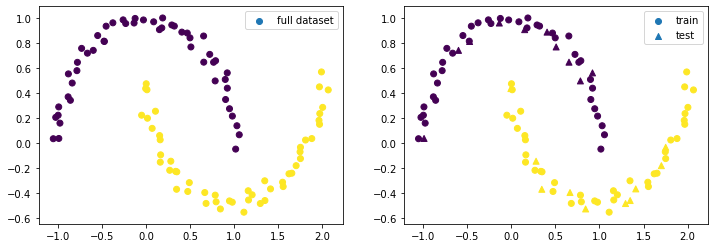

In [14]:
X, Y = make_moons(n_samples=100, noise=0.05, random_state=9)
xtr, xte, ytr, yte = train_test_split(X, Y, test_size=.2, random_state=9)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(X[:,0], X[:,1], c=Y, label='full dataset')
axes[1].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[0].legend()
axes[1].legend()

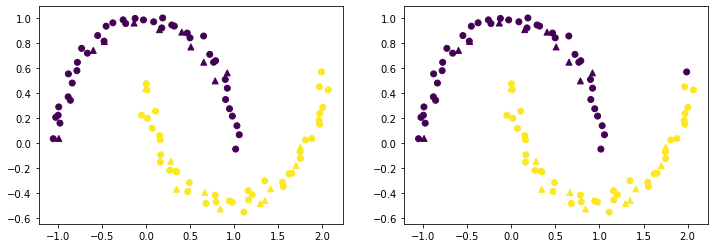

In [15]:
DTC = DecisionTreeClassification(xtr.shape[1], max_depth=5, split='random_k')
DTC.train(xtr, ytr)
yp1 = DTC.predict(xtr)
yp2 = DTC.predict(xte)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[0].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[1].scatter(xtr[:,0], xtr[:,1], c=yp1, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yp2, marker='^', label='test')

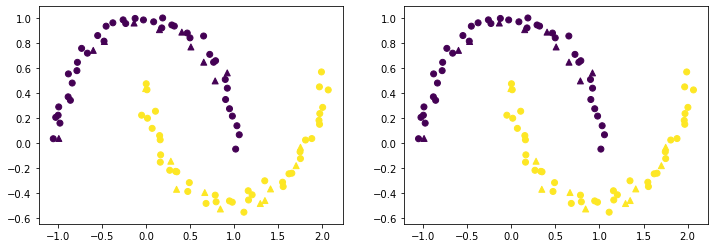

In [16]:
DTC = DecisionTreeClassification(xtr.shape[1], max_depth=5, split='best')
DTC.train(xtr, ytr)
yp1 = DTC.predict(xtr)
yp2 = DTC.predict(xte)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[0].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[1].scatter(xtr[:,0], xtr[:,1], c=yp1, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yp2, marker='^', label='test')

In [17]:
RF = RandomForest()
A = np.arange(100).reshape(20,5)
B = np.random.randint(0, 3, 20)
x, y, fd = RF.RSM(A,B)
print(B)
print(A)
print()
print(x)
print()
print(y)
print(fd)

[0 2 1 0 0 1 1 2 0 0 0 0 1 0 0 1 2 1 2 1]
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]
 [30 31 32 33 34]
 [35 36 37 38 39]
 [40 41 42 43 44]
 [45 46 47 48 49]
 [50 51 52 53 54]
 [55 56 57 58 59]
 [60 61 62 63 64]
 [65 66 67 68 69]
 [70 71 72 73 74]
 [75 76 77 78 79]
 [80 81 82 83 84]
 [85 86 87 88 89]
 [90 91 92 93 94]
 [95 96 97 98 99]]

[[87]
 [88]
 [89]
 [27]
 [28]
 [29]
 [77]
 [78]
 [79]
 [87]
 [88]
 [89]
 [92]
 [93]
 [94]
 [72]
 [73]
 [74]
 [22]
 [23]
 [24]
 [32]
 [33]
 [34]
 [ 2]
 [ 3]
 [ 4]
 [62]
 [63]
 [64]
 [27]
 [28]
 [29]
 [22]
 [23]
 [24]
 [47]
 [48]
 [49]
 [32]
 [33]
 [34]
 [67]
 [68]
 [69]
 [ 2]
 [ 3]
 [ 4]
 [52]
 [53]
 [54]
 [12]
 [13]
 [14]
 [97]
 [98]
 [99]
 [97]
 [98]
 [99]]

[1 1 1 1 2 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1]
[2 3 4]


In [53]:
ri = np.random.randint(0, 1e5, 1)[0]
ri

8580

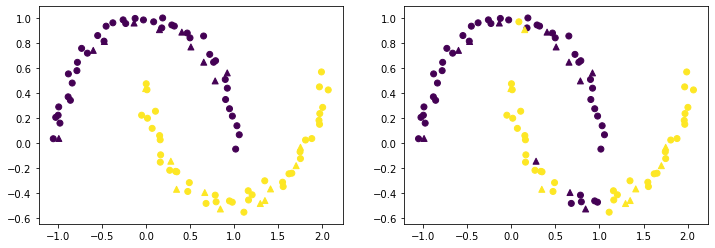

In [54]:
RF = RandomForest(tree_n=7, random_state=ri, max_depth=4, split='random_k', res_func='p_argmax')
RF.train(xtr, ytr)
yp1 = RF.predict(xtr)
yp2 = RF.predict(xte)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[0].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[1].scatter(xtr[:,0], xtr[:,1], c=yp1, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yp2, marker='^', label='test')

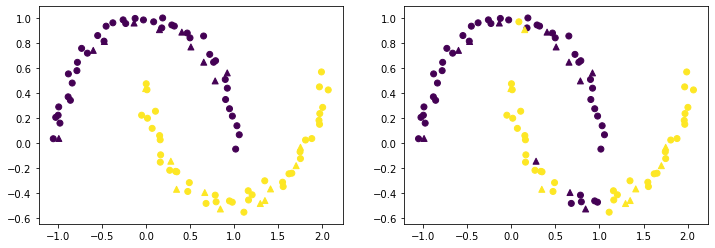

In [55]:
RF = RandomForest(tree_n=7, random_state=ri, max_depth=4, split='random_k', res_func='mean')
RF.train(xtr, ytr)
yp1 = RF.predict(xtr)
yp2 = RF.predict(xte)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[0].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[1].scatter(xtr[:,0], xtr[:,1], c=yp1, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yp2, marker='^', label='test')

In [77]:
from sklearn import ensemble

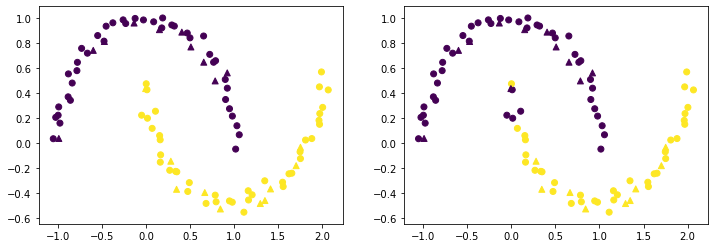

In [76]:
RF = ensemble.RandomForestClassifier(
    n_estimators=5, criterion='entropy', max_depth=4, random_state=13)
RF.fit(xtr, ytr)
yp1 = RF.predict(xtr)
yp2 = RF.predict(xte)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[0].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[1].scatter(xtr[:,0], xtr[:,1], c=yp1, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yp2, marker='^', label='test')

In [49]:
a = np.array([]).reshape(-1,1)
print(a.shape)
a = a.reshape(0,0)
a.shape

(0, 1)


(0, 0)

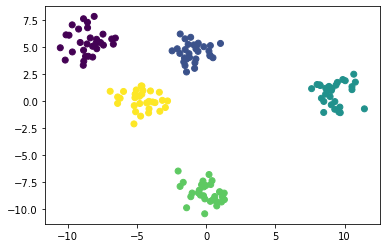

In [66]:
X, Y = make_blobs(n_samples=150, n_features=2, centers=5, random_state=7)
plt.scatter(X[:,0], X[:,1], c=Y)

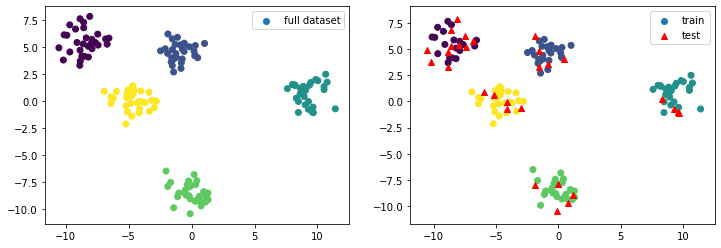

In [68]:
xtr, xte, ytr, yte = train_test_split(X, Y, test_size=.2, random_state=9)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(X[:,0], X[:,1], c=Y, label='full dataset')
axes[1].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c='r', marker='^', label='test')

axes[0].legend()
axes[1].legend()

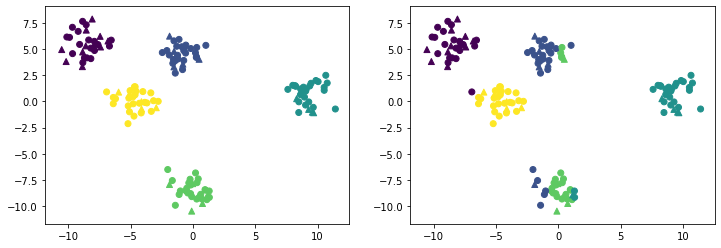

In [79]:
RF = RandomForest(tree_n=4, random_state=ri, max_depth=4, split='random_k', res_func='p_argmax')
RF.train(xtr, ytr)
yp1 = RF.predict(xtr)
yp2 = RF.predict(xte)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[0].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[1].scatter(xtr[:,0], xtr[:,1], c=yp1, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yp2, marker='^', label='test')

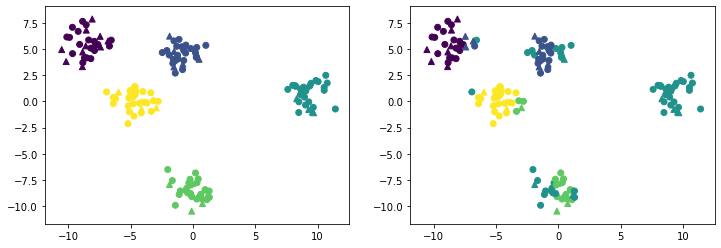

In [80]:
RF = RandomForest(tree_n=4, random_state=ri, max_depth=4, split='random_k', res_func='mean')
RF.train(xtr, ytr)
yp1 = RF.predict(xtr)
yp2 = RF.predict(xte)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[0].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[1].scatter(xtr[:,0], xtr[:,1], c=yp1, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yp2, marker='^', label='test')

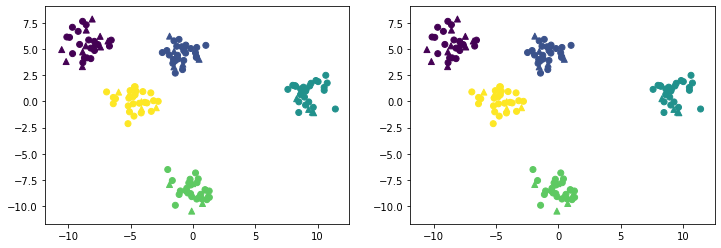

In [87]:
RF = ensemble.RandomForestClassifier(
    n_estimators=1, criterion='entropy', bootstrap=False, max_depth=4, random_state=ri)
RF.fit(xtr, ytr)
yp1 = RF.predict(xtr)
yp2 = RF.predict(xte)
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].scatter(xtr[:,0], xtr[:,1], c=ytr, label='train')
axes[0].scatter(xte[:,0], xte[:,1], c=yte, marker='^', label='test')

axes[1].scatter(xtr[:,0], xtr[:,1], c=yp1, label='train')
axes[1].scatter(xte[:,0], xte[:,1], c=yp2, marker='^', label='test')